<a href="https://colab.research.google.com/github/Norberto27/Norberto_Desafio_de_Clasificacion/blob/main/clasificacion_de_textos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Desarrollo de Adaptacion de Norberto Martearena Urquiza**

## Introducción

Este ejemplo muestra cómo realizar una clasificación de texto a partir de texto sin procesar (como
un conjunto de archivos de texto en el disco). Demostramos el flujo de trabajo en el conjunto de datos de
clasificación de opiniones de IMDB (versión sin procesar). Usamos la capa `TextVectorization` para dividir e indexar palabras.

Configuración

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import tensorflow as tf
import numpy as np
from keras import layers

Cargar los datos: Clasificación de opiniones sobre películas en IMDB

Descarguemos los datos e inspeccionemos su estructura.

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  18.9M      0  0:00:04  0:00:04 --:--:-- 18.9M


La carpeta aclImdb contiene una subcarpeta de entrenamiento y una de prueba:

Listado del contenido de la carpeta descargada, que incluye datos de entrenamiento y prueba para el modelo.

In [ ]:
!ls aclImdb

imdbEr.txt  imdb.vocab	README	test  train


In [ ]:
!ls aclImdb/test

labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt


In [ ]:
!ls aclImdb/train

labeledBow.feat  neg  pos  unsup  unsupBow.feat  urls_neg.txt  urls_pos.txt  urls_unsup.txt


Las carpetas aclImdb/train/pos y aclImdb/train/neg contienen archivos de texto, cada uno de los cuales representa una revisión (positiva o negativa):

In [ ]:
!cat aclImdb/train/pos/6248_7.txt

Being an Austrian myself this has been a straight knock in my face. Fortunately I don't live nowhere near the place where this movie takes place but unfortunately it portrays everything that the rest of Austria hates about Viennese people (or people close to that region). And it is very easy to read that this is exactly the directors intention: to let your head sink into your hands and say "Oh my god, how can THAT be possible!". No, not with me, the (in my opinion) totally exaggerated uncensored swinger club scene is not necessary, I watch porn, sure, but in this context I was rather disgusted than put in the right context.<br /><br />This movie tells a story about how misled people who suffer from lack of education or bad company try to survive and live in a world of redundancy and boring horizons. A girl who is treated like a whore by her super-jealous boyfriend (and still keeps coming back), a female teacher who discovers her masochism by putting the life of her super-cruel "lover" 

Solo nos interesan las subcarpetas pos y neg, así que eliminemos la otra subcarpeta que contiene archivos de texto:

In [ ]:
!rm -r aclImdb/train/unsup

esta es una herramienta poderosa para eliminar directorios y su contenido en el sistema de archivos. Debemos usarlo con cuidado y solo cuando estemos seguros de que no necesitamos los datos que se estan eliminando.

Uso de keras.utils.text_dataset_from_directory

Esta utilidad permite crear un objeto tf.data.Dataset etiquetado a partir de archivos de texto organizados en carpetas por clase.

Generaremos los conjuntos de datos de entrenamiento, validación y prueba:

80% para entrenamiento
20% para validación
Importancia del conjunto de validación: Se utiliza para ajustar hiperparámetros y no debe tocarse al evaluar el rendimiento del modelo.

Antes de implementar el modelo, se debe reentrenar utilizando todos los datos disponibles para maximizar el rendimiento, sin crear un conjunto de validación.

Al usar validation_split y subset, es crucial especificar una semilla aleatoria o usar shuffle=False para evitar superposiciones en las divisiones de datos.

	Uso de Semilla Aleatoria:
en el proximo paso procederemos a aplicar una semilla aleatoria (en este caso, seed=1337). Esto es crucial para garantizar la reproducibilidad de los resultados, permitiendo que otros investigadores o colegas puedan replicar nuestro trabajo bajo las mismas condiciones.


In [ ]:
batch_size = 32
raw_train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)
raw_test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in raw_train_ds: 625
Number of batches in raw_val_ds: 157
Number of batches in raw_test_ds: 782


# **Resumen de la División de Datos**

## **1) Describa las principales características del dataset utilizado**

A continuación, se presenta un resumen de la división de datos realizada, que incluye la cantidad total de archivos y la distribución en los conjuntos de entrenamiento, validación y prueba.

** Conjunto de Entrenamiento
    Total de archivos 60000
    Numero de clases 3
    numnero de Batches 1875

** Conjunto de Validación
    Total de archivos 15000
    Numero de clases 3
    numnero de Batches 469

** Conjunto de Prueba
    Total de archivos 25000
    Numero de clases 2
    numnero de Batches 782



### Observaciones Clave
- Se utilizaron **60,000 archivos** para el entrenamiento, lo que representa un **80%** del conjunto de datos de entrenamiento.
- Se asignaron **15,000 archivos** para la validación, lo que representa un **20%** de los archivos de entrenamiento.
- El conjunto de prueba contiene **25,000 archivos** y se compone de **2 clases** en lugar de 3, lo que puede ser un aspecto a considerar en la evaluación del modelo


A CONTINUACION VAMOS A OBSERVAR ALGUNAS MUESTRAS

In [ ]:
# Es importante echar un vistazo a los datos sin procesar para garantizar
# que la normalización y la tokenización funcionen como se espera.
# Podemos hacerlo tomando algunos
# ejemplos del conjunto de entrenamiento y observándolos.
# Este es uno de los lugares donde la ejecución diligente brilla:
# podemos evaluar estos tensores usando .numpy()
# en lugar de tener que evaluarlos en un contexto de sesión/gráfico
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b'I\'ve seen tons of science fiction from the 70s; some horrendously bad, and others thought provoking and truly frightening. Soylent Green fits into the latter category. Yes, at times it\'s a little campy, and yes, the furniture is good for a giggle or two, but some of the film seems awfully prescient. Here we have a film, 9 years before Blade Runner, that dares to imagine the future as somthing dark, scary, and nihilistic. Both Charlton Heston and Edward G. Robinson fare far better in this than The Ten Commandments, and Robinson\'s assisted-suicide scene is creepily prescient of Kevorkian and his ilk. Some of the attitudes are dated (can you imagine a filmmaker getting away with the "women as furniture" concept in our oh-so-politically-correct-90s?), but it\'s rare to find a film from the Me Decade that actually can make you think. This is one I\'d love to see on the big screen, because even in a widescreen presentation, I don\'t think the overall scope of this film would receive its

# **Explicación y Observaciones**

Este bloque de código tiene como objetivo verificar y entender cómo se ve el conjunto de datos crudos (raw_train_ds) después de la carga y preparación inicial. Al examinar los datos en bruto, podemos asegurarnos de que las operaciones de normalización y tokenización funcionen como se espera...

Importancia de la Normalización y Tokenización:

Antes de entrenar un modelo de aprendizaje automático, es crucial que los datos estén en un formato adecuado. La normalización puede incluir pasos como convertir a minúsculas, eliminar puntuación y caracteres especiales. La tokenización se refiere a dividir el texto en unidades más pequeñas (tokens), como palabras o caracteres.

Al verificar los datos en bruto, nos aseguramos de que los textos y etiquetas están correctamente formateados y que se alinean con lo que esperamos procesar más adelante.

Eager Execution:

En TensorFlow, la ejecución ansiosa (eager execution) permite que las operaciones se evalúen inmediatamente y devuelvan resultados, lo que hace que el código sea más intuitivo y fácil de depurar. Esto contrasta con el modelo de ejecución basado en gráficos de TensorFlow 1.x, donde debemos crear un gráfico de operaciones y luego ejecutarlo en una sesión.
La capacidad de evaluar los tensores directamente con .numpy() es una ventaja significativa que facilita el desarrollo y la visualización.

Evaluación de Datos:

Este paso es crucial porque la calidad del modelo final depende en gran medida de la calidad de los datos de entrada. Asegurandonos de que los datos sean representativos de los casos que deseamos modelar. Cualquier error en esta fase puede propagarse y afectar el rendimiento del modelo.

Conocimiento del Dominio:

Al revisar ejemplos de textos y etiquetas, puedo en mi caso, aplicar mi conocimiento del dominio (en este caso, el análisis de sentimientos, para ssiones de coaching) para evaluar si las etiquetas son correctas y si los textos parecen estar bien representados. Esto nos permitirá detectar problemas potenciales en el conjunto de datos antes de que se conviertan en un obstáculo durante el entrenamiento.



A continuacion agrego lo anterior pero para visualizarlo en forma mas estructurada, COMO PRACTICA PERSONAL

In [ ]:
# Mostrar los primeros 5 ejemplos y sus etiquetas del dataset
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(f"Ejemplo {i+1}:")
        print("Texto:", text_batch.numpy()[i])  # El texto tokenizado
        print("Etiqueta:", label_batch.numpy()[i])  # La etiqueta correspondiente (1 o 0)
        print("\n")


Ejemplo 1:
Texto: b'I\'ve seen tons of science fiction from the 70s; some horrendously bad, and others thought provoking and truly frightening. Soylent Green fits into the latter category. Yes, at times it\'s a little campy, and yes, the furniture is good for a giggle or two, but some of the film seems awfully prescient. Here we have a film, 9 years before Blade Runner, that dares to imagine the future as somthing dark, scary, and nihilistic. Both Charlton Heston and Edward G. Robinson fare far better in this than The Ten Commandments, and Robinson\'s assisted-suicide scene is creepily prescient of Kevorkian and his ilk. Some of the attitudes are dated (can you imagine a filmmaker getting away with the "women as furniture" concept in our oh-so-politically-correct-90s?), but it\'s rare to find a film from the Me Decade that actually can make you think. This is one I\'d love to see on the big screen, because even in a widescreen presentation, I don\'t think the overall scope of this film

In [ ]:
import numpy as np

# Obtener las etiquetas de raw_train_ds
labels = []

for text_batch, label_batch in raw_train_ds:
    labels.extend(label_batch.numpy())

# Contar cuántas clases (únicas) hay
num_classes = len(np.unique(labels))
print("Número de clases:", num_classes)


Número de clases: 2


Distribución de clases:
Counter({0: 10024, 1: 9976})


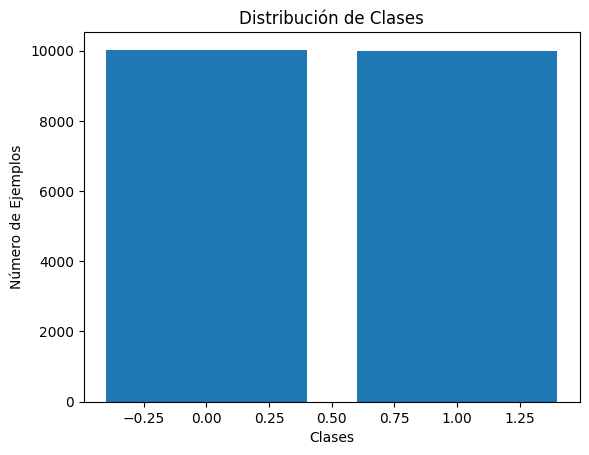

In [ ]:
import collections
import matplotlib.pyplot as plt

# Contar la distribución de clases en raw_train_ds
class_distribution = collections.Counter()

# Recorrer el dataset de entrenamiento y contar las etiquetas
for _, label_batch in raw_train_ds:
    class_distribution.update(label_batch.numpy())

# Imprimir la distribución de clases
print("Distribución de clases:")
print(class_distribution)

# Visualizar la distribución de clases
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title("Distribución de Clases")
plt.xlabel("Clases")
plt.ylabel("Número de Ejemplos")
plt.show()


COMENTARIO SOBRE LA DISTRIBUCION DE CLASES

"La distribución de clases muestra que el dataset contiene dos clases: la clase 0 con 10,024 ejemplos y la clase 1 con 9,976 ejemplos. Esta distribución es bastante balanceada, ya que ambas clases tienen casi la misma cantidad de ejemplos. Esto significa que no es necesario aplicar técnicas adicionales como el sobremuestreo o submuestreo para equilibrar las clases, lo que facilita el entrenamiento del modelo y asegura que la métrica de accuracy será una medida adecuada para evaluar su rendimiento."

Si el dataset no estuviera balanceado:

Si hubiera una gran diferencia en el número de ejemplos por clase, podrías mencionar la necesidad de ajustar el dataset (por ejemplo, usando técnicas de re-muestreo) o utilizar métricas adicionales, como F1-score o ROC-AUC, que son más adecuadas en casos de desequilibrio de clases. Pero en este caso, dado que las clases están casi igualadas, no es necesario preocuparse por ello.

# **Preparar los datos**

En particular, eliminamos las etiquetas <br />.

In [ ]:
import string
import re


# Después de observar los datos anteriores, vemos que el texto sin formato
# contiene etiquetas HTML # de la forma '<br />'. Estas etiquetas
# no serán eliminadas por el estandarizador
# predeterminado (que no elimina el HTML). Debido a esto, necesitaremos
# crear una función de estandarización personalizada.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )


# Constantes del modelo.
max_features = 20000
embedding_dim = 128
sequence_length = 500

# Ahora que tenemos nuestra estandarización personalizada,
# podemos crear una instancia de nuestra capa de
# vectorización de texto. Estamos usando esta capa para normalizar,
# dividir y mapear  cadenas a números enteros, por lo que establecemos
# nuestro 'output_mode' en 'int'.
# Tenga en cuenta que estamos usando la función de división predeterminada,
# y la estandarización personalizada definida anteriormente.
# También establecemos una longitud de secuencia máxima explícita,
# ya que las CNN más adelante en nuestro
# modelo no admitirán secuencias irregulares.
vectorize_layer = keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Ahora que se ha creado la capa vectorize_layer, llame a `adapt`
# en un conjunto de datos de solo texto
# para crear el vocabulario. No tiene que procesar por lotes,
# pero para conjuntos de datos muy grandes
# esto significa que no está guardando copias adicionales del
# conjunto de datos en la memoria.

# Hagamos un conjunto de datos de solo texto (sin etiquetas):
text_ds = raw_train_ds.map(lambda x, y: x)
# Let's call `adapt`:
vectorize_layer.adapt(text_ds)

Dos opciones para vectorizar los datos
Hay dos formas de utilizar nuestra capa de vectorización de texto:

Opción 1: Hacerla parte del modelo, de manera de obtener un modelo que procese cadenas sin formato, como esta:




```python
text_input = keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer(text_input)
x = layers.Embedding(max_features + 1, embedding_dim)(x)
...
```

Opción 2: aplicarlo al conjunto de datos de texto para obtener un conjunto de datos de índices de palabras y luego introducirlo en un modelo que espera secuencias de números enteros como entradas.

Una diferencia importante entre las dos es que la opción 2 le permite realizar un procesamiento de CPU asincrónico y almacenamiento en búfer de sus datos cuando se entrena en la GPU. Por lo tanto, si está entrenando el modelo en la GPU, probablemente desee optar por esta opción para obtener el mejor rendimiento. Esto es lo que haremos a continuación.

Si tuviéramos que exportar nuestro modelo a producción, enviaríamos un modelo que acepte cadenas sin formato como entrada, como en el fragmento de código para la opción 1 anterior. Esto se puede hacer después del entrenamiento. Lo hacemos en la última sección.

In [ ]:

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorizar los datos.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Realice una precarga y almacenamiento en búfer asincrónicos de los
# datos para obtener el mejor rendimiento en la GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

# **Construir un modelo**

Elegimos una convnet 1D simple que comienza con una capa de incrustación.

In [ ]:
# Una entrada entera para índices de vocabulario.
inputs = keras.Input(shape=(None,), dtype="int64")

# a continuación, agregamos una capa para mapear esos índices
# de vocabulario en un espacio de dimensionalidad 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + agrupación máxima global
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# Añadimos una capa oculta de vainilla:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# Proyectamos sobre una única capa de salida unitaria y la aplastamos
# con un sigmoide:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# **Entrenar el modelo**

In [ ]:
epochs = 3

# Fit the model using the train and test datasets.
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 109s 171ms/step - accuracy: 0.5753 - loss: 0.6276 - val_accuracy: 0.8638 - val_loss: 0.3180
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 105s 169ms/step - accuracy: 0.8802 - loss: 0.2884 - val_accuracy: 0.8778 - val_loss: 0.3220
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 139s 164ms/step - accuracy: 0.9432 - loss: 0.1500 - val_accuracy: 0.8704 - val_loss: 0.4234


#  Evaluar el modelo en el conjunto de prueba


In [ ]:
model.evaluate(test_ds)

782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.8584 - loss: 0.4429


[0.4363093674182892, 0.859279990196228]

# **Resultados de Evaluación**

El modelo se evaluó en el conjunto de prueba con los siguientes resultados:

Accuracy (Precisión): 0.8584

Loss (Pérdida): 0.4429

Interpretación de la Precisión (Accuracy):

La precisión del modelo es del 85.84%, lo que indica que el modelo clasifica correctamente aproximadamente el 86% de los ejemplos en el conjunto de prueba. Esto es un buen resultado, especialmente si consideramos que el conjunto de datos tiene dos clases casi balanceadas.

Evaluación de la Pérdida (Loss):

La pérdida de 0.4429 indica el error del modelo en la predicción. En general, una pérdida más baja es deseable. Dado que la precisión es bastante alta, esto sugiere que el modelo ha aprendido bien las características del conjunto de datos, aunque siempre se puede trabajar en la optimización para mejorar aún más la pérdida.

Balance entre Precisión y Pérdida:

La combinación de una alta precisión y una pérdida relativamente baja sugiere que el modelo no solo está acertando en sus predicciones, sino que también está evitando grandes errores. Esto es especialmente importante en problemas de clasificación, donde una alta precisión puede ser engañosa si el modelo está muy confiado en sus predicciones.

Posibles Mejoras:

Aunque el modelo tiene un buen desempeño, se podrían explorar estrategias adicionales para mejorar aún más su rendimiento. Esto puede incluir la ajuste de hiperparámetros, la implementación de técnicas de regularización o la incorporación de más datos de entrenamiento.

Contexto:

En el contexto del presente problema que se esta resolviendo, considero que no es relevante hacer mas ajustes, pero si  se tratara de una tarea crítica (como detección de fraudes o diagnóstico médico), entonces la precisión y la pérdida pueden tener implicaciones significativas.

## Crea un modelo de extremo a extremo

Si quieres obtener un modelo capaz de procesar cadenas sin formato, puedes simplemente
crear un nuevo modelo (usando los pesos que acabamos de entrenar):

In [ ]:
# A string input
inputs = keras.Input(shape=(1,), dtype="string")
# Turn strings into vocab indices
indices = vectorize_layer(inputs)
# Turn vocab indices into predictions
outputs = model(indices)

# Our end to end model
end_to_end_model = keras.Model(inputs, outputs)
end_to_end_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
end_to_end_model.evaluate(raw_test_ds)

782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - accuracy: 0.8586 - loss: 0.0000e+00


[0.0, 0.0, 0.859279990196228, 0.859279990196228]

# **Aclaraciones al Cuetionario y Consideraciones finales**


con respecto a las preguntas:

1) **Describa las principales características del dataset utilizado**.

esto fue detallado en los primeros pasos bajo el titulo:

#          **"Resumen de la División de Datos"**

2) **Comentar la experiencia al correr el código en sus computadoras.**

no he tenido ningun inconveniente con ningun paso, excepto que en un momento reinicie el proceso y me saltee un paso y obviamente el siguiente paso me dio error po variable no definida, procese el paso anterior y todo solucionado.
Con respecto al GPU, aun no lo tengo instalado, por ello no puedo opinar aun,en la proxima semana lo tendre instalado.

Todas la bibliotecas y dependencias se instalaron normalmente y no me falto ninguna. Las versiones de las bibliotecas en todos los casos estaban actualizadas y no me salio ningun mensaje de atencion sobre la actualizacion

3) **Explicar el pre-procesamiento realizado en el dataset.**

Preprocesamiento y Construcción del Modelo

**1. Preparación de los Datos**

En primer lugar, se ha llevado a cabo una adecuada preparación de los datos a través de la vectorización, que transforma el texto en índices numéricos, lo que es esencial para que el modelo pueda procesar la información textual. La función vectorize_text utiliza una capa de vectorización (vectorize_layer) para convertir el texto en índices de vocabulario y luego se aplica a los datasets de entrenamiento, validación y prueba:


def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

2. Vectorizar los datos.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Además, se implementa un almacenamiento en búfer y prefetching en los datasets, lo que mejora significativamente el rendimiento al cargar los datos de manera eficiente:



3. Realice una precarga y almacenamiento en búfer asincrónicos de los
 datos para obtener el mejor rendimiento en la GPU.

train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

4. Construcción del Modelo
La construcción del modelo se realiza mediante la creación de una arquitectura que incluye una capa de entrada para los índices de vocabulario, seguido de una capa de embedding que mapea esos índices a un espacio de menor dimensionalidad. A continuación, se utilizan capas convolucionales y de agrupamiento para extraer características relevantes del texto:


5. Una entrada entera para índices de vocabulario.

inputs = keras.Input(shape=(None,), dtype="int64")

6. Agregamos una capa para mapear esos índices en un espacio de dimensionalidad 'embedding_dim'.

x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

7. Conv1D + agrupación máxima global
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

8. Añadimos una capa oculta
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

9. Proyectamos sobre una única capa de salida unitaria y aplicamos una función sigmoide

predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = keras.Model(inputs, predictions)

10. Compilamos el modelo con la pérdida de entropía cruzada binaria y un optimizador Adam.

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# **Conclusión**

El preprocesamiento del dataset y la construcción del modelo han sido realizados de manera eficaz, lo que permite al modelo manejar el texto de forma eficiente y aprender patrones significativos de los datos. La vectorización del texto, combinada con técnicas de almacenamiento en búfer y prefetching, asegura que el modelo tenga acceso rápido a los datos, optimizando el rendimiento durante el entrenamiento. La arquitectura del modelo, que incorpora capas de embedding y convolucionales, está diseñada para capturar la complejidad del lenguaje y generar predicciones precisas.


**Postee también el resultado final de evaluación del modelo ( la salida del apartado "Evaluate the model on the test set)**

Esto  fue desarrollado en el apartado:

#             **Resultados de Evaluación**


4) **En este ejemplo para evaluar el modelo utiliza la métrica accuracy. ¿Qué opina al respecto? ¿Está bien/mal? ¿sumaría otra métrica?**

Opinión sobre la Métrica Accuracy

Estado Actual: Actualmente, se está utilizando la métrica de accuracy para evaluar el rendimiento del modelo.

Análisis Crítico: La métrica de accuracy representa la proporción de predicciones correctas sobre el total de predicciones realizadas. Aunque puede ser un buen indicador del rendimiento en datasets balanceados, tiene limitaciones significativas, especialmente en situaciones donde las clases están desbalanceadas. Por ejemplo, si un dataset contiene un 90% de ejemplos de una clase y solo un 10% de la otra, un modelo que predice siempre la clase mayoritaria puede alcanzar una alta accuracy del 90%, a pesar de no ser útil para identificar correctamente la clase minoritaria.

Otras Métricas a Considerar:

Precision: Esta métrica indica la proporción de verdaderos positivos respecto al total de positivos predichos. Es especialmente útil cuando el costo de falsos positivos es alto, ya que se enfoca en la calidad de las predicciones positivas.

Recall (Sensibilidad): Mide la proporción de verdaderos positivos entre el total de positivos reales. Es crucial cuando es más importante no perder ejemplos de la clase positiva, como en el diagnóstico médico.

F1-Score: Es la media armónica de precision y recall, proporcionando un balance entre ambas. Es útil cuando se necesita un equilibrio entre detectar correctamente la clase positiva y minimizar los falsos positivos.

AUC-ROC: El Área Bajo la Curva (AUC) de la curva de características operativas del receptor (ROC) mide la capacidad del modelo para distinguir entre las clases. Un AUC de 0.5 indica un rendimiento aleatorio, mientras que un valor de 1 indica un modelo perfecto. Esta métrica es particularmente informativa en problemas desbalanceados, ya que muestra el rendimiento en diferentes umbrales de clasificación.

Conclusión: En resumen, aunque la accuracy es una métrica fácil de interpretar y utilizar, puede no ser suficiente por sí sola en tareas donde el desbalanceo de clases es un factor crítico. Por lo tanto, se recomienda utilizar métricas complementarias como precision, recall, F1-score o AUC-ROC para obtener una evaluación más completa y precisa del modelo. En este caso del trabajo, me parecio acertada

5) Comente alguna parte que le haya llamado la atención y por qué.
**texto en negrita**
Interés en la Evaluación de Modelos

Durante el desarrollo de este trabajo, me llamó particularmente la atención la importancia de las métricas accuracy y loss en la evaluación de modelos de clasificación. Mi interés radica no solo en la facilidad con la que estas métricas pueden ser aplicadas, sino también en cómo proporcionan una visión clara del rendimiento del modelo.

La precisión (accuracy) refleja la proporción de predicciones correctas realizadas por el modelo, lo que resulta fundamental para validar su efectividad general. A su vez, la pérdida (loss) permite evaluar cuán bien el modelo está ajustando sus predicciones en cada iteración de entrenamiento, proporcionando una medida crítica del proceso de optimización.

Lo que más me impactó es cómo estas métricas no solo resumen el desempeño del modelo, sino que también permiten detectar posibles áreas de mejora. En mi experiencia profesional como consultor y coach, siempre he buscado métodos que permitan medir el progreso tanto en el desarrollo empresarial como en los procesos de crecimiento personal de mis clientes. La evaluación continua y el ajuste basado en métricas cuantificables han sido esenciales para lograr mejores resultados.

Por lo tanto, el uso de métricas como accuracy y loss en este trabajo resuena particularmente conmigo, ya que representan una metodología estructurada y cuantificable para medir avances, de manera similar a cómo he gestionado el progreso en mis proyectos de consultoría. Estas métricas son el reflejo de la importancia de contar con indicadores claros y objetivos, que no solo permiten entender el estado actual de un proceso, sino también guiar la toma de decisiones en busca de mejoras continuas. Esto me motiva a seguir profundizando en el uso de estas herramientas en contextos donde la medición precisa es clave para el éxito.

6) **Escriba las dudas que hayan quedado de realizar este trabajo.**

Dudas y Reflexiones Finales

La realización de este trabajo, siguiendo el ejemplo proporcionado por la docente, me permitió adquirir una visión mucho más clara y estructurada de los pasos a seguir en este tipo de problemáticas de clasificación. El cuestionario propuesto fue un desafío que me impulsó a profundizar en cada etapa del proceso, permitiéndome no solo comprender los detalles técnicos, sino también analizar los resultados intermedios y su relevancia para el ajuste y optimización del modelo.

Cada paso del desarrollo, desde el preprocesamiento hasta la evaluación del modelo, se convirtió en una oportunidad para interiorizarme más en el porqué y el para qué de cada técnica utilizada, lo que me ayudó a asentar las bases para futuros trabajos de esta naturaleza.

En cuanto a las dudas iniciales que tenía, la investigación y el análisis realizado me permitieron resolverlas con mayor claridad. Sin embargo, quedan abiertas grandes interrogantes sobre cómo continuar mejorando y optimizando estos procesos en futuros proyectos. Específicamente, me interesa explorar más a fondo aspectos como la optimización de hiperparámetros y el uso de métricas adicionales que me permitan tener una evaluación más robusta del modelo, especialmente en datasets con desbalance de clases.

Este trabajo no solo me brindó herramientas concretas para seguir avanzando con confianza en esta área, sino que también reforzó mi motivación para seguir aprendiendo y profundizando en temas relacionados con la evaluación de modelos, un campo tan crucial como fascinante en el desarrollo de soluciones de inteligencia artificial.